# Preliminary Training Script 

In [1]:
# imports
# %pip install bert_race/requirements.txt -qqq
%pip install transformers==4.11.3 -qqq
!pip install pytorch_pretrained_bert==0.4.0 -qqq
# %conda install -c conda-forge ipywidgets



%load_ext autoreload
%autoreload 2
# %pip install transformers --upgrade

!pip install wandb -qqq
import wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy

In [3]:
import numpy as np
import transformers 
print(transformers.__version__)

from loss import LossCriterion, LOSS_REGISTRY

from module.bert_optim import RAdam

import torch
torch.cuda.empty_cache()
import gc
# del variables
gc.collect()

4.11.3


20

In [4]:
# import torch
# import pickle
# %load_ext autoreload
# %autoreload 2
from utils.tokenization_utils import read_data

In [5]:
bucket = 'support-bert-data'
data_location = f's3://{bucket}'

In [6]:
# %pip install -r bert_race/requirements.txt
# %cp bert_race/pytorch_pretrained_bert/tokenization.py utils/tokenization.py
# %cp bert_race/pytorch_pretrained_bert/file_utils.py utils/file_utils.py

from utils.tokenization import BertTokenizer 
from utils.tokenization_utils import convert_examples_to_features
from data_utils.utils import AverageMeter

In [7]:
bert_model = "bert-base-uncased"
do_lower_case = True
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)

In [8]:
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# %cp bert_race/pytorch_pretrained_bert/modeling.py utils/modeling.py
# %cp bert_race/pytorch_pretrained_bert/optimization.py utils/optimization.py

import torch
from utils.modeling import BertForMultipleChoice, BertConfig, BertEmbeddings
from utils.file_utils import PYTORCH_PRETRAINED_BERT_CACHE, WEIGHTS_NAME, CONFIG_NAME
from utils.optimization import BertAdam, WarmupLinearSchedule

In [9]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset, IterableDataset)
from tqdm import tqdm, trange

In [10]:
# from utils.tokenization_utils import build_tensor
def select_field(features, field):
    return [
        [
            choice[field]
            for choice in feature.choices_features
        ]
        for feature in features
    ]

def build_tensor(features):
    all_input_ids = torch.tensor(select_field(features, 'input_ids'),
                                 dtype=torch.long)
    all_input_mask = torch.tensor(select_field(features, 'input_mask'),
                                  dtype=torch.long)
    all_segment_ids = torch.tensor(select_field(features, 'segment_ids'),
                                   dtype=torch.long)
    all_label = torch.tensor([f.label for f in features],
                             dtype=torch.long)
    return TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label)


In [11]:
# args
seed = 30
do_lower_case = True
bert_model = "bert-base-uncased"

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
        torch.cuda.manual_seed_all(seed)
print(n_gpu)

1


In [13]:
val_examples = read_data(data_location,'dev')
train_examples = read_data(data_location,'train')

After sorted: support-bert-data/dev/0.txt
After sorted: support-bert-data/train/0.txt


In [14]:
# test_examples = read_data(data_location,'test')

def build_dataset(config, examples):
    
    test_features = convert_examples_to_features(
                examples, tokenizer, config['max_seq_length'], True)
    test_data = build_tensor(test_features)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data,
                                 sampler=test_sampler,
                                 batch_size=4)
    
    return test_dataloader

test_dataloader = build_dataset({'max_seq_length': 128}, examples = train_examples)

val_datalaoder = build_dataset({'max_seq_length': 128}, examples = val_examples)

3289 race_id: support-bert-data/train/0:0, context_sentence: when tech opens info session and when he tries to close it, it hangs and will not close. i have included a screen shot as to what process  hangs in the device manager. i have tried to uninstall and reinstall the pdf application but it did not help, start_ending: what kind of issue occurred?, ending_0: a performance issue., ending_1: [NOA], ending_2: a protocol issue., label: 0
0
557 race_id: support-bert-data/dev/0:0, context_sentence: [AN56] data is showing as queued, almost all to [AN16], [AN31] seems to transmit okay. please see screen shot and [AN25] requirements log. i also submitted error report from admin client on device., start_ending: how would you describe your issue?, ending_0: the {[AN56]} protocols were transferred to {[AN31]} but could not be saved on your device (pc/{[AN1]})., ending_1: the {[AN56]} protocols are not sent., ending_2: [NOA], label: 1
0


In [15]:
train_questions = set([sample.start_ending.lower() for sample in train_examples])
val_questions = set([sample.start_ending.lower() for sample in val_examples])
test_questions = set([sample.start_ending.lower() for sample in train_examples])
unseen_questions = train_questions - val_questions
unseen_questions

{'can other devices connetc via your wlan network?',
 'is the affetced {[an13]} in the same sub-net as the {[an25]} device that is unable to find it?',
 'is the affetced {[an21]} visible in the {[an25]} "connetcion manager"?'}

In [16]:
unseen_samples = [example for example in val_examples if example.start_ending.lower()=='which {itool} is affected?']
len(unseen_samples)

2

In [17]:
unseen_datalaoder = build_dataset({'max_seq_length': 128}, examples = unseen_samples)

2 race_id: support-bert-data/dev/94:10, context_sentence: Dear Support,

the ICOM  is not visible in the ISTA?s Connection Manager when it?s connected via WLAN.
But, if we trying to using LAN Cable Network it's working.

Whether we should arrange schedule for remote session [DAT] is ok? what do you think?

Best Regards,


Langga Pradana Putra, start_ending: Which {ITOOL} is affected?, ending_0: [NOA], ending_1: {ICOM}, ending_2: {IMIB R2}, label: 1
0


In [18]:
[q for q in val_questions if q not in train_questions]

['which {itool} is affected?']

In [19]:
train_questions

{'can other devices connect via your wlan network?',
 'can other devices connetc via your wlan network?',
 'did the issue occur for the first time immediately after performing a firmware update?',
 'how can we help you?',
 'how would you describe your issue?',
 'is an error message displayed?',
 'is the affected {itool} visible in the {ista} "connection manager"?',
 'is the affetced {[an13]} in the same sub-net as the {[an25]} device that is unable to find it?',
 'is the affetced {[an21]} visible in the {[an25]} "connetcion manager"?',
 'the newest {[an25]} version in the "software catalogue" and the previous one are supported. older versions are not. are you using a supported version?',
 'the newest {ista} version in the "software catalogue" and the previous one are supported. older versions are not. are you using a supported version?',
 'what kind of issue occurred?',
 'when does the issue occur?',
 'which error message is displayed?',
 'which {[an21]} is affetced?'}

In [20]:
def load_checkpoint(model, optimizer, load_path):
    if device.type=='cpu':
        checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
    else:
        checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [21]:
config = {
             'multi_gpu_on':False,
             'max_seq_length': 64,
             'adam_eps': 6, 
             'adv_epsilon': 1e-6,
             'adv_train': 1,
             'adv_noise_var': 1e-5,
             'adv_norm_level': 0,
             'adv_step_size': 1e-3,
             'bin_on': False,
             'cuda': 1,
             'encoder_type': None,
             'fp16': True,
             'fp16_opt_level': 'O1',
             'global_grad_clipping': 1.0,
             'grad_accumulation_step': 1,
             'grad_clipping': 1,
             'local_rank': -1,
             'mkd_opt': 0,
             'scheduler_type': 'ms',
             'task_def_list': None,
             'warmup': 0.1,
             'warmup_schedule': 'warmup_linear',
             'weight_decay': 0,
             'weighted_on': False,
             'state_dict': None,
             'loss': 'LossCriterion.CeCriterion',
             'epochs': 5,
             'batch_size': 2,
             'adv_k': 1,
             'learning_rate':5e-5,
             'adv_p_norm': 'inf',
             'adv_alpha': 1,
             'optimizer': 'adam',
             'adv_loss': 'LossCriterion.SymKlCriterion',
             'weight': 0,
             'log_per_updates': 128,
             'have_lr_scheduler': True,
             'patience': 2,
             'early_stopping_loss': 'train_loss'
    }

In [22]:
from sklearn.metrics import accuracy_score, f1_score

def calc_metrics(predictions, labels):
    return {'acc': np.round(100*accuracy_score(labels, predictions)),
            'f1': np.round(100*f1_score(labels, predictions, average="weighted"), 2)}
     

def evaluation(model, dataloader, device, val_loss_meter=None, mode='val'):
    assert mode in ['test', 'val', 'dev', 'train']
    with torch.no_grad():
        [metrics,
         predictions,
         loss,
         batch_size,
         scores] = eval_model(model, dataloader, device)
    if mode in ['val', 'dev']:
        assert val_loss_meter is not None
        val_loss_meter.update(loss.item(), batch_size)
    return val_loss_meter, metrics, scores
                         
def eval_model(model, dataloader, device):
    overall_predictions = []
    overall_labels = []
    golds = []
    scores = []
    ids = []
    overall_metrics = {}
    for step, batch in enumerate(tqdm(dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        loss, logits = model(input_ids,
                             segment_ids,
                             input_mask,
                             label_ids,
                             return_logits=True)
        
        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()
        
        predictions = np.argmax(logits, axis=1)
        prediction_confidence = np.max(logits, axis=1)
        metrics = calc_metrics(predictions, list(label_ids))
        
        correct_label_prediction = prediction_confidence[predictions==label_ids]
        wrong_label_prediction = prediction_confidence[predictions!=label_ids]
        
        prediction_confidence = {'correct_confidence': correct_label_prediction,
                                'wrong_confidence': wrong_label_prediction}
        overall_predictions.extend(predictions)
        overall_labels.extend(label_ids)
        
    return metrics, predictions, overall_labels, overall_predictions


In [23]:
from sklearn.metrics import accuracy_score, f1_score
from scipy.special import softmax

def calc_metrics(predictions, labels):
    return {'acc': np.round(100*accuracy_score(labels, predictions)),
            'f1': np.round(100*f1_score(labels, predictions, average="weighted"), 2)}
     

def evaluation(model, dataloader, device, mode='val'):
    assert mode in ['test', 'val', 'dev', 'train']
    with torch.no_grad():
        [metrics,
         predictions,
         loss,
         batch_size,
         scores] = eval_model(model, dataloader, device)
    return loss.item(), batch_size, metrics, scores
                         
def eval_model(model, dataloader, device):
    overall_predictions = []
    overall_labels = []
    golds = []
    scores = []
    ids = []
    overall_metrics = {}
    
    
    prediction_confidence_summary = {'correct_confidence': [],
                            'wrong_confidence': []}
    for step, batch in enumerate(tqdm(dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        loss, logits = model(input_ids,
                             segment_ids,
                             input_mask,
                             label_ids,
                             return_logits=True)
        
        logits = logits.detach().cpu().numpy()
        label_ids = label_ids.to('cpu').numpy()
        
        predictions = np.argmax(logits, axis=1)
        
        normalized_confidence = softmax(logits)
        prediction_confidence = np.max(normalized_confidence, axis=1)
        
        correct_label_prediction = prediction_confidence[predictions==label_ids]
        wrong_label_prediction = prediction_confidence[predictions!=label_ids]
        
        
        prediction_confidence_summary['correct_confidence'].extend(list(correct_label_prediction))
        prediction_confidence_summary['wrong_confidence'].extend((wrong_label_prediction))
        overall_predictions.extend(predictions)
        overall_labels.extend(label_ids)
    
    metrics = calc_metrics(overall_predictions, list(overall_labels))
        
    return metrics, predictions, loss, len(predictions), prediction_confidence_summary


In [24]:
def _get_param_groups(network):
        param_optimizer = [n for n in list(network.named_parameters()) if 'pooler' not in n[0]]
        no_decay = ['bias', 'gamma', 'beta', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        return optimizer_parameters

In [25]:
model = BertForMultipleChoice.from_pretrained(bert_model,
                                              cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE), 'distributed_{}'.format(-1)),
                                              num_choices=3)

from pytorch_pretrained_bert import BertAdam as Adam
optimizer_parameters = _get_param_groups(model)
optimizer = Adam(optimizer_parameters,
                                  lr=config['learning_rate'],
                                  warmup=config['warmup'],
                                  t_total=len(test_dataloader),
                                  max_grad_norm=config['grad_clipping'],
                                  schedule=config['warmup_schedule'],
                                  weight_decay=config['weight_decay'])

In [26]:
load_path = 'model_ckppm4xbdzl.pt' # good model (test acc ~80)
load_path = 'model_ckp3jqfdmfc.pt' # very bad test-model (test acc ~35%)
load_path = 'model_ckp1u95gxlg.pt' # seems good (test ~75%)
load_path = 'model_ckp1qvsjzqf.pt' # seems good (test ~92%)
load_path = 'model_ckpe0s55geq.pt' # seems bad (test ~46%)
model, optimizer, epoch = load_checkpoint(model, optimizer, load_path) 
model.to(device)
model.eval()

BertForMultipleChoice(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
           

In [27]:
output = eval_model(model, test_dataloader, device)

Iteration:   0%|          | 0/823 [00:00<?, ?it/s]

[2021-10-23 22:22:40.869 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-c630bdb4e3ad8d68ab6e5727a214:2618 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-10-23 22:22:40.892 pytorch-1-6-gpu-py3-ml-g4dn-xlarge-c630bdb4e3ad8d68ab6e5727a214:2618 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


Iteration: 100%|██████████| 823/823 [03:05<00:00,  4.44it/s]


In [53]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
from scipy.special import softmax

(array([1.000e+01, 5.200e+01, 1.350e+02, 1.125e+03, 3.130e+02, 9.100e+01,
        3.200e+01, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([0.08333286, 0.083333  , 0.08333314, 0.08333329, 0.08333343,
        0.08333357, 0.08333372, 0.08333386, 0.08333401, 0.08333415,
        0.08333429], dtype=float32),
 <BarContainer object of 10 artists>)

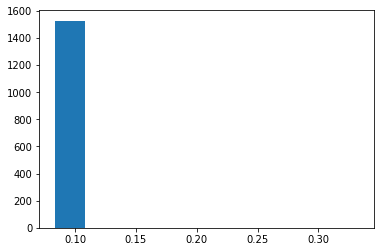

In [28]:
import matplotlib.pyplot as plt
plt.hist(output[4]['correct_confidence'])
plt.hist(output[4]['wrong_confidence'])

In [29]:
len(output[4]['correct_confidence']), len(output[4]['wrong_confidence'])

(1527, 1762)

In [30]:
output

({'acc': 46.0, 'f1': 46.43},
 array([2]),
 tensor(1.0986, device='cuda:0', grad_fn=<NllLossBackward>),
 1,
 {'correct_confidence': [0.08333342,
   0.08333342,
   0.08333342,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333342,
   0.083333254,
   0.083333254,
   0.083333336,
   0.08333335,
   0.08333335,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333309,
   0.08333377,
   0.083333336,
   0.083333336,
   0.08333337,
   0.08333337,
   0.08333337,
   0.08333337,
   0.083333455,
   0.083333455,
   0.083333924,
   0.083333455,
   0.08333373,
   0.083333254,
   0.083333455,
   0.083333455,
   0.083333455,
   0.083333455,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333342,
   0.08333327,
   0.08333335,
   0.08333335,
   0.08333343,
   0.08333343,
  

'Which error message is displayed?'

In [31]:
import matplotlib.pyplot as plt
plt.hist(output[4]['correct_confidence'])

IndexError: tuple index out of range

In [ ]:
def create_model():
    
    for name, param in model.named_parameters():
        ln = 24
        if name.startswith('bert.encoder'):
        	l = name.split('.')
        	ln = int(l[3])
      
        if name.startswith('bert.embeddings') or ln < 6:
#         	print(name)  
        	param.requires_grad = False
    
    model.to(device)
    
    return model

def _model_init(config, model, state_dict=None, num_train_step=-1):
        total_param = sum([p.nelement() for p in model.parameters() if p.requires_grad])
        if config['cuda']:
            if config['local_rank'] != -1:
                model = model.to(device)
            else:
                model = model.to(device)
        network = model
        if state_dict:
            missing_keys, unexpected_keys = network.load_state_dict(state_dict['state'], strict=False)

        optimizer_parameters = _get_param_groups(network)
#         try:
        optimizer, scheduler = _setup_optim(config,optimizer_parameters, state_dict, num_train_step, network)
#         except Exceptio#work: {network}')
#         optimizer.zero_grad()

        #if self.config["local_rank"] not in [-1, 0]:
        #    torch.distributed.barrier()

        if config['local_rank'] != -1:
            mnetwork = torch.nn.parallel.DistributedDataParallel(network, device_ids=[self.config["local_rank"]], output_device=self.config["local_rank"], find_unused_parameters=True)
        elif config['multi_gpu_on']:
            mnetwork = torch.nn.DataParallel(network, device_ids=[0, 1, 2])
        else:
            mnetwork = network
        task_loss_criterion = _setup_lossmap(config)
        adv_task_loss_criterion = _setup_adv_lossmap(config)
        adv_teacher = _setup_adv_training(config, adv_task_loss_criterion)
        
        return [mnetwork,
                task_loss_criterion,
                adv_task_loss_criterion,
                adv_teacher,
                optimizer_parameters,
                optimizer,
                scheduler]

In [16]:
from perturbation import SmartPerturbation

def _setup_adv_training(config, adv_task_loss_criterion):
        adv_teacher = None
        if config.get('adv_train', False):
            adv_teacher = SmartPerturbation(config['adv_epsilon'],
                    config['multi_gpu_on'],
                    config['adv_step_size'],
                    config['adv_noise_var'],
                    config['adv_p_norm'],
                    config['adv_k'],
                    config['fp16'],
                    config['encoder_type'],
                    loss_map=adv_task_loss_criterion,
                    norm_level=config['adv_norm_level'])
        return adv_teacher
            
def _setup_adv_lossmap(config):
        task_def_list: List[TaskDef] = config['task_def_list']
        adv_task_loss_criterion = []
        if config.get('adv_train', False):
            cs = config['adv_loss']
            assert cs in ['LossCriterion.SymKlCriterion', 'LossCriterion.KlCriterion']
            if cs == 'LossCriterion.SymKlCriterion':
                lc = LOSS_REGISTRY[LossCriterion.SymKlCriterion](name='Adv Loss func of task {}: {}'.format(0, cs))
                adv_task_loss_criterion.append(lc)
            else:
                lc = LOSS_REGISTRY[LossCriterion.KlCriterion](name='Adv Loss func of task {}: {}'.format(0, cs))
                adv_task_loss_criterion.append(lc)
            return adv_task_loss_criterion
            
def _setup_lossmap(config):
        task_def_list: List[TaskDef] = config['task_def_list']
        task_loss_criterion = []
        cs = config['loss'] # this loss has later to be passed through config file
        if cs=='LossCriterion.CeCriterion':
            lc = LOSS_REGISTRY[LossCriterion.CeCriterion](name='Loss func of task {}: {}'.format(0, cs)) 
            task_loss_criterion.append(lc)
        else:
            raise NotImplementedError
        return task_loss_criterion
            
def _get_param_groups(network):
        param_optimizer = [n for n in list(network.named_parameters()) if 'pooler' not in n[0]]
        no_decay = ['bias', 'gamma', 'beta', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0}
        ]
        return optimizer_parameters
    
from pytorch_pretrained_bert import BertAdam as Adam

def _setup_optim(config, optimizer_parameters, state_dict=None, num_train_step=-1, network=None):
    if config['optimizer'] == 'sgd':
        optimizer = optim.SGD(optimizer_parameters, config['learning_rate'],
                                   weight_decay=config['weight_decay'])

    elif config['optimizer'] == 'adamax':
        optimizer = Adamax(optimizer_parameters,
                                config['learning_rate'],
                                warmup=config['warmup'],
                                t_total=num_train_step,
                                max_grad_norm=config['grad_clipping'],
                                schedule=config['warmup_schedule'],
                                weight_decay=config['weight_decay'])
        if config.get('have_lr_scheduler', False): config['have_lr_scheduler'] = False
    elif config['optimizer'] == 'radam':
        optimizer = RAdam(optimizer_parameters,
                                config['learning_rate'],
                                warmup=config['warmup'],
                                t_total=num_train_step,
                                max_grad_norm=config['grad_clipping'],
                                schedule=config['warmup_schedule'],
                                eps=config['adam_eps'],
                                weight_decay=config['weight_decay'])
        if config.get('have_lr_scheduler', False): config['have_lr_scheduler'] = False
        # The current radam does not support FP16.
        config['fp16'] = False
    elif config['optimizer'] == 'adam':
        optimizer = Adam(optimizer_parameters,
                              lr=config['learning_rate'],
                              warmup=config['warmup'],
                              t_total=num_train_step,
                              max_grad_norm=config['grad_clipping'],
                              schedule=config['warmup_schedule'],
                              weight_decay=config['weight_decay'])
        if config.get('have_lr_scheduler', False): config['have_lr_scheduler'] = False
    else:
        raise RuntimeError('Unsupported optimizer: %s' % opt['optimizer'])

    if state_dict and 'optimizer' in state_dict:
        optimizer.load_state_dict(state_dict['optimizer'])

    if config['fp16']:
        try:
            from apex import amp
            global amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(network, optimizer, opt_level=config['fp16_opt_level'])
        network = model
        optimizer = optimizer

    if config.get('have_lr_scheduler', False):
        if config.get('scheduler_type', 'rop') == 'rop':
            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=config['lr_gamma'], patience=3)
        elif config.get('scheduler_type', 'rop') == 'exp':
            scheduler = ExponentialLR(optimizer, gamma=config.get('lr_gamma', 0.95))
        else:
            milestones = [int(step) for step in config.get('multi_step_lr', '10,20,30').split(',')]
            scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=config.get('lr_gamma'))
    else:
        scheduler = None
        
    return optimizer, scheduler

def perturbated_loss():
    smartPerturbation = SmartPerturbation(epsilon=1e-6,
                    multi_gpu_on=False,
                    step_size=1e-3,
                    noise_var=1e-5,
                    norm_p='inf',
                    k=1,
                    fp16=False,
                    encoder_type=EncoderModelType.BERT,
                    loss_map=[SymKlCriterion],
                    norm_level=0)
    
    return smartPerturbation

def _norm_grad(grad, norm_p, epsilon, eff_grad=None, sentence_level=False):
        eff_direction = 0
        if norm_p == 'l2':
            if sentence_level:
                direction = grad / (torch.norm(grad, dim=(-2, -1), keepdim=True) + epsilon)
            else:
                direction = grad / (torch.norm(grad, dim=-1, keepdim=True) + epsilon)
        elif norm_p == 'l1':
            direction = grad.sign()
        else:
            if sentence_level:
                direction = grad / (grad.abs().max((-2, -1), keepdim=True)[0] + epsilon)
            else:
                direction = grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
                eff_direction = eff_grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
        return direction, eff_direction
    
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    #print(outputs,outputs == labels)
    return np.sum(outputs == labels)

from loss import stable_kl

def generate_noise(embed, mask, epsilon=1e-5):
    noise = embed.data.new(embed.size()).normal_(0, 1) *  epsilon
    noise.detach()
    noise.requires_grad_()
    return noise

In [29]:
def check_save_ckp(metric, best_metric, model, optimizer, save_path, epoch, metric_name='train_loss'):
    if metric < best_metric:
        wandb.summary[f"best_{metric_name}"] = metric
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch
        }, save_path)
        return metric
    return best_metric
    
def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

In [30]:


def training_loop(config,
                  train_dataloader,
                  eval_dataloader,
                  model,
                  task_loss_criterion,
                  adv_task_loss_criterion,
                  adv_teacher,
                  optimizer_parameters,
                  optimizer,
                  scheduler,
                  run_id,
                  save_path=''):
    
    # preliminaries for training loop
    loss_scale=0
    output_dir="large_models"
    %mkdir large_models
    output_train_file = os.path.join(output_dir, "train_results.txt")
    output_smart_train_file = os.path.join(output_dir, "smart_train_results.txt")
    loss_writer = open(output_train_file, "w",1)
    smart_loss_writer = open(output_smart_train_file, "w",1)

    train_loss_meter = AverageMeter()
    adv_loss_meter = AverageMeter()
    emb_val_meter = AverageMeter()
    eff_perturb_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    
    local_updates = 0
    updates =0
    best_loss = np.inf
    last_es_criterion = np.inf
    accumulated_tr_loss = 0
    accumulated_std_tr_loss = 0
    overall_wrong_confidence_scores = []
    overall_correct_confidence_scores = []
    trigger_times = 0
    stopping = False
    best_metrics = {}

    for epoch in trange(int(config['epochs']), desc="Epoch"):
                tr_loss = 0
                last_tr_loss = 0
                std_loss = 0

                nb_tr_examples, nb_tr_steps = 0, 0
                for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
                    batch = tuple(t.to(device) for t in batch)
                    input_ids, input_mask, segment_ids, label_ids = batch
                    logits = model(input_ids, segment_ids, input_mask)

                    # compute loss
                    loss = task_loss_criterion[0](logits, label_ids, config['weight'], ignore_index=-1)
                    
                    if config['adv_train']:
                        if config['multi_gpu_on']:
                            embed = torch.stack([model.module.bert.embeddings(ids, mask) for ids, mask in zip(input_ids, input_mask)]) # recover batch-embeddings
                        else:
                            embed = torch.stack([model.bert.embeddings(ids, mask) for ids, mask in zip(input_ids, input_mask)]) # recover batch-embeddings
                        noise = generate_noise(embed, input_mask, config['adv_noise_var'])
                        for step in range(config['adv_k']):
                            adv_logits = torch.stack([model(input_ids=ids,
                                                               token_type_ids=mask,
                                                               attention_mask=segment,
                                                               inputs_embeds=in_embed)[-1] for ids, mask, segment, in_embed in zip(input_ids,
                                                                                                                                   input_mask,
                                                                                                                                   segment_ids,
                                                                                                                                   noise+embed)
                                                     ]
                                                    )
                            adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
                            delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
                            norm = delta_grad.norm()
                            if (torch.isnan(norm) or torch.isinf(norm)):
                                adv_loss = emb_val = eff_perturbation = 0
                                break
                            eff_delta_grad = delta_grad * config['adv_step_size']
                            delta_grad = noise + delta_grad * config['adv_step_size']
                            noise, eff_noise = _norm_grad(delta_grad,
                                                          norm_p=config['adv_p_norm'],
                                                          epsilon=config['adv_epsilon'],
                                                          eff_grad=eff_delta_grad,
                                                          sentence_level=config['adv_norm_level'])
                            noise = noise.detach()
                            noise.requires_grad_()
                        adv_logits = torch.stack([model(input_ids=ids,
                                               token_type_ids=mask,
                                               attention_mask=segment,
                                               inputs_embeds=in_embed)[-1] for ids, mask, segment, in_embed in zip(input_ids,
                                                                                                                   input_mask,
                                                                                                                   segment_ids,
                                                                                                                   noise+embed)
                                                 ]
                                                )
                        adv_loss = adv_task_loss_criterion[-1](logits, adv_logits, ignore_index=-1)
                        emb_val = embed.detach().abs().mean()
                        try:
                            eff_perturb = eff_noise.detach().abs().mean()
                            eff_perturb_meter.update(eff_perturb.item(), config['batch_size'])
                        except AttributeError:
                            eff_perturb = 0
                            eff_perturb_meter.update(0, config['batch_size'])

                        loss += config['adv_alpha']*adv_loss
                        adv_loss_meter.update(adv_loss.item(), config['batch_size'])
                        emb_val_meter.update(emb_val.item(), config['batch_size'])
                    
                    else:
                        adv_loss = 0
                        emb_val = 0
                        adv_loss_meter.update(adv_loss, config['batch_size'])
                        emb_val_meter.update(emb_val, config['batch_size'])
                    train_loss_meter.update(loss.item(), config['batch_size'])
                    
                    
                    

                    loss = loss /config.get('grad_accumulation_step', 1)
                    if config['fp16']:
                        with amp.scale_loss(loss, optimizer) as scaled_loss:
                            scaled_loss.backward()

                    local_updates += 1
                    if local_updates % config.get('grad_accumulation_step', 1) == 0:
                        if config['global_grad_clipping'] > 0:
                            if config['fp16']:
                                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer),
                                                               config['global_grad_clipping'])
                            else:
                                torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                               config['global_grad_clipping'])
                        updates += 1
                        # reset number of the grad accumulation
                        optimizer.step()
                        optimizer.zero_grad() 
                    
    
#                     accumulated_tr_loss+=train_loss_meter.val
#                     accumulated_std_tr_loss+=train_loss_meter.val-adv_loss_meter.val
                    if (updates) % (config['log_per_updates']) == 0 or updates == 1:
        
                        print('evaluating model......')
                        wandb.log({"avg standard loss": train_loss_meter.avg - adv_loss_meter.avg})
                        wandb.log({"avg regularized loss": train_loss_meter.avg})
                                                
#                         wandb.log({"moving avg standard batch loss": accumulated_std_tr_loss/config['log_per_updates']})
#                         wandb.log({"moving avg regularized batch loss": accumulated_tr_loss/config['log_per_updates']})
                        
                        # Early stopping
                        if config['early_stopping_loss']=='train_loss':
                            es_criterion = train_loss_meter.avg
                        
#                         accumulated_tr_loss = 0
#                         accumulated_std_tr_loss = 0
                        
                        best_loss=check_save_ckp(train_loss_meter.val,
                                                 best_loss,
                                                 model,
                                                 optimizer,
                                                 f'model_ckp{run_id}.pt',
                                                 epoch,
                                                 'train_loss')
                        
                        _, metrics, _ = evaluation(model,
                                             train_dataloader,
                                             device,
                                             mode='train')
                
                        for key, val in metrics.items():
                            wandb.log({f'train {key}': val})
                            if val < best_metrics.get(f'train {key}', np.inf):
                                wandb.summary[f'train {key}'] = val
                                best_metrics[f'train {key}'] = val
                            
                        val_loss_meter, metrics, scores = evaluation(model,
                                                                     eval_dataloader,
                                                                     device,
                                                                     val_loss_meter,
                                                                     mode='val')
                        for key, val in metrics.items():
                            wandb.log({f'val {key}': val})
                            if val < best_metrics.get(f'val {key}', np.inf):
                                wandb.summary[f'val {key}'] = val
                                best_metrics[f'val {key}'] = val
                        
                        wandb.log({"avg eval loss": val_loss_meter.avg})
                        if val_loss_meter.avg < best_metrics.get('best_avg_val_loss', np.inf):
                            wandb.summary[f"best eval loss"] = val_loss_meter.avg
                            best_metrics['best_avg_val_loss'] = val_loss_meter.avg
                        _, metrics, scores = evaluation(model,
                                                        test_dataloader,
                                                        device,
                                                        mode='test')
                        for key, val in metrics.items():
                            wandb.log({f'test {key}': val})
                            if val < best_metrics.get(f'test {key}', np.inf):
                                wandb.summary[f'test {key}'] = val
                                best_metrics[f'test {key}'] = val
                            
                        if config['early_stopping_loss']!='train_loss':
                            es_criterion = val_loss_meter.avg
                        
                        
                        if es_criterion > last_es_criterion:
                            trigger_times += 1

                            if trigger_times >= config['patience']:
                                stopping=True

                        else:
                            trigger_times = 0

                        last_es_criterion = es_criterion
                    
                        overall_correct_confidence_scores.extend(scores['correct_confidence'])
                        overall_wrong_confidence_scores.extend(scores['wrong_confidence'])
                        
                    
                    overall_correct_confidence_scores = [[sigmoid(s)] for s in overall_correct_confidence_scores]
                    overall_wrong_confidence_scores = [[sigmoid(s)] for s in overall_wrong_confidence_scores]
                    correct_table = wandb.Table(data=overall_correct_confidence_scores, columns=["confidence scores"])
                    wrong_table = wandb.Table(data=overall_wrong_confidence_scores, columns=["confidence scores"])
                    
                    wandb.log({f'correct_pred_scores epoch {epoch}': wandb.plot.histogram(correct_table,
                                                                    "scores",
                                                                    title="(Correct) Prediction Score Distribution")})
                    wandb.log({f'wrong_pred_scores epoch {epoch}': wandb.plot.histogram(wrong_table,
                                                                    "scores",
                                                                    title="(Wrong) Prediction Score Distribution")})
                    
                    overall_wrong_confidence_scores = []
                    overall_correct_confidence_scores = []
                    
                    wandb.log({'batch adv_loss': train_loss_meter.avg})
                    wandb.log({'batch std_loss': train_loss_meter.avg - adv_loss_meter.avg})
                    if stopping==True:
                        print(f'STOPPING at epoch {epoch}')
                        return model
#                     if nb_tr_examples % 512 == 0 or False:
            
            

                        
                        
#                         loss_log = (train_loss_meter.val - last_tr_loss)*1.0/512
#                         print(nb_tr_examples,loss_log)
#                         loss_writer.write("%d %f \n" % (nb_tr_examples,loss_log))
#                         smart_loss_writer.write(("%d %f \n" % (nb_tr_examples,train_loss_meter.val)))
#                         last_tr_loss = tr_loss

#                         # evaluate model
#                         model.eval()
#                         tr_val_loss = 0
#                         eval_loss, eval_accuracy = 0, 0
#                         nb_eval_steps, nb_eval_examples = 0, 0
#                         total_logits = []
#                         total_labels = []
#                         for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
#                             input_ids = input_ids.to(device)
#                             input_mask = input_mask.to(device)
#                             segment_ids = segment_ids.to(device)
#                             label_ids = label_ids.to(device)

#                             with torch.no_grad():
#                                 tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
#                                 logits = model(input_ids, segment_ids, input_mask)

#                             logits = logits.detach().cpu().numpy()
#                             label_ids = label_ids.to('cpu').numpy()
#                             tmp_eval_accuracy = accuracy(logits, label_ids)

#                             eval_loss += tmp_eval_loss.mean().item()
#                             eval_accuracy += tmp_eval_accuracy

#                             nb_eval_examples += input_ids.size(0)
#                             nb_eval_steps += 1

#                             total_logits.append(logits)
#                             total_labels.append(label_ids)

#                         total_logits = np.concatenate(total_logits)
#                         total_labels = np.concatenate(total_labels)

#                         eval_loss = eval_loss / nb_eval_steps
#                         eval_accuracy = eval_accuracy / nb_eval_examples

#                         wandb.log({'eval_loss': eval_loss,
#                                   'eval_accuracy': eval_accuracy})

In [33]:
# build_dataset
# train_dataloader, eval_dataloader = build_dataset(wandb.config)

def train():
    default_config = {
             'multi_gpu_on':False,
             'max_seq_length': 64,
             'adam_eps': 6, 
             'adv_epsilon': 1e-6,
             'adv_train': 1,
             'adv_noise_var': 1e-5,
             'adv_norm_level': 0,
             'adv_step_size': 1e-3,
             'bin_on': False,
             'cuda': 1,
             'encoder_type': None,
             'fp16': True,
             'fp16_opt_level': 'O1',
             'global_grad_clipping': 1.0,
             'grad_accumulation_step': 1,
             'grad_clipping': 1,
             'local_rank': -1,
             'mkd_opt': 0,
             'scheduler_type': 'ms',
             'task_def_list': None,
             'warmup': 0.1,
             'warmup_schedule': 'warmup_linear',
             'weight_decay': 0,
             'weighted_on': False,
             'state_dict': None,
             'loss': 'LossCriterion.CeCriterion',
             'epochs': 5,
             'batch_size': 4,
             'adv_k': 1,
             'learning_rate':5e-5,
             'adv_p_norm': 'inf',
             'adv_alpha': 1,
             'optimizer': 'adam',
             'adv_loss': 'LossCriterion.SymKlCriterion',
             'weight': 0,
             'log_per_updates': 128,
             'have_lr_scheduler': True,
             'patience': 2,
             'early_stopping_loss': 'train_loss'
    }
    
    wandb.init(project="master-thesis", config=default_config)
    
    device = default_config['cuda']
    
    config = wandb.config
    run_id = wandb.run.id
    
#     # build_dataset
#     train_dataloader, eval_dataloader = build_dataset(config)
    
    # create model
    model = create_model()
    
    # initialize model and losses
    [mnetwork,
     task_loss_criterion,
     adv_task_loss_criterion,
     adv_teacher,
     optimizer_parameters,
     optimizer,
     scheduler] = _model_init(config=config, model=model, num_train_step=len(train_dataloader))
    
    # training mode ON
    mnetwork.train()
    
    # wandb watch
    wandb.watch(model)
    
    # train/eval
    training_loop(config,
                  train_dataloader,
                  eval_dataloader,
                  mnetwork,
                  task_loss_criterion,
                  adv_task_loss_criterion,
                  adv_teacher,
                  optimizer_parameters,
                  optimizer,
                  scheduler,
                  run_id)
    
    # stop wandb
    wandb.finish()

In [ ]:
train()

avg eval loss,█▃▁
avg regularized loss,█▂▁
avg standard loss,█▁▁
batch adv_loss,▇███▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch std_loss,███▇▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test acc,▁▇█
test f1,▁▇█
val acc,▁▁▁▁██
val f1,▁▁▁▁█▄
avg eval loss,36.99938
avg regularized loss,13.01055


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
mkdir: cannot create directory ‘large_models’: File exists


Iteration:   0%|          | 0/1645 [00:00<?, ?it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
evaluating model......



Iteration:   0%|          | 1/1645 [00:12<5:37:58, 12.33s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0



Iteration:   0%|          | 2/1645 [00:14<4:10:51,  9.16s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0



Iteration:   0%|          | 3/1645 [00:15<3:10:02,  6.94s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0



Iteration:   1%|          | 12/1645 [00:32<57:05,  2.10s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



Iteration:   4%|▍         | 65/1645 [02:15<50:12,  1.91s/it]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0



Iteration:   8%|▊         | 127/1645 [04:13<47:56,  1.89s/it]

evaluating model......



Iteration:  16%|█▌        | 255/1645 [08:19<45:07,  1.95s/it]

evaluating model......



Iteration:  20%|█▉        | 324/1645 [10:32<41:41,  1.89s/it]

In [ ]:
wandb.agent(sweep_id, train)

# Custom metrics

In [ ]:
# 0,1,2 classes (irrelevant - misleading)
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    #print(outputs,outputs == labels)
    return np.sum(outputs == labels)

# group data by question -> we want to look at the accuracy and f1 score for each question 

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForMultipleChoice


In [ ]:
# !jupyter nbextension enable --py widgetsnbextension

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForMultipleChoice, DistilBertModel
import torch

# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
# model = DistilBertForMultipleChoice.from_pretrained('distilbert-base-cased')

In [ ]:
def create_distil_model():
    
    for name, param in distil_model.named_parameters():
#         param.requires_grad = False
        ln = 24
        if name.startswith('distilbert.encoder'):
        	l = name.split('.')
        	ln = int(l[3])
      
        if name.startswith('distilbert.embeddings') or ln < 6:
#         	print(name)  
        	param.requires_grad = False
    
    distil_model.to(device)
    
    return distil_model

# from utils.tokenization import BertTokenizer tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=do_lower_case)

In [ ]:
from utils.modeling import BertEmbeddings

class RaceDistilBert(DistilBertModel):
    def __init__(self, config):
        super(RaceDistilBert, self).__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = self.transformer
    
    def forward(self, input_ids,
                token_type_ids=None,
                attention_mask=None,
                output_all_encoded_layers=True,
                inputs_embeds=None):
        '''overwrite forward method'''
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)

        P_att = torch.zeros_like(input_ids)
        Q_att = torch.zeros_like(input_ids)
        A_att = torch.zeros_like(input_ids)
        token_ids = torch.zeros_like(input_ids)

        P_att[token_type_ids==0] = 1
        Q_att[token_type_ids==1] = 1
        A_att[token_type_ids==2] = 1

        token_ids[token_type_ids > 0] = 1

        # We create a 3D attention mask from a 2D tensor mask.
        # Sizes are [batch_size, 1, 1, to_seq_length]
        # So we can broadcast to [batch_size, num_heads, from_seq_length, to_seq_length]
        # this attention mask is more simple than the triangular masking of causal attention
        # used in OpenAI GPT, we just need to prepare the broadcast dimension here.
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

        # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
        # masked positions, this operation will create a tensor which is 0.0 for
        # positions we want to attend and -10000.0 for masked positions.
        # Since we are adding it to the raw scores before the softmax, this is
        # effectively the same as removing these entirely.
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        P_att = P_att.unsqueeze(1).unsqueeze(2)
        P_att = P_att.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        P_att = (1.0 - P_att) * -10000.0

        Q_att = Q_att.unsqueeze(1).unsqueeze(2)
        Q_att = Q_att.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        Q_att = (1.0 - Q_att) * -10000.0

        A_att = A_att.unsqueeze(1).unsqueeze(2)
        A_att = A_att.to(dtype=next(self.parameters()).dtype) # fp16 compatibility
        A_att = (1.0 - A_att) * -10000.0

        if inputs_embeds is None:
            embedding_output = self.embeddings(input_ids, token_ids)
        else:
            embedding_output = inputs_embeds
#             print(f'shape inputs_embeds: {len(inputs_embeds)}, and shape embeddings: {len(self.embeddings(input_ids, token_ids))}')

#         self.noise = self.generate_noise(embedding_output, attention_mask[0], epsilon=1e-5)
        
        print(f'embedding output: {embedding_output}')
        return embedding_output, extended_attention_mask,output_all_encoded_layers
        try:
            encoded_layers = self.encoder(embedding_output,
                                          extended_attention_mask,
                                          output_all_encoded_layers=output_all_encoded_layers)
        except TypeError as e:
            encoded_layers = self.encoder(embedding_output,
                                          extended_attention_mask,
                                          output_hidden_states=output_all_encoded_layers)
        
#         self.adv_encoded_layers = self.encoder(embedding_output+self.noise,
#                                       extended_attention_mask,
#                                       output_all_encoded_layers=output_all_encoded_layers)
        
        
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        if not output_all_encoded_layers:
            encoded_layers = encoded_layers[-1]

        return extended_attention_mask,P_att,Q_att,A_att,sequence_output
    
class RaceDistilBertMultipleChoice(DistilBertForMultipleChoice):
    def __init__(self, config):
        super(RaceDistilBertMultipleChoice, self).__init__(config)
        self.distilbert = dmodel
    
    def get_config(self):
        return self.config
        

In [ ]:
dmodel = RaceDistilBert.from_pretrained('distilbert-base-uncased')
dmodel_mc = RaceDistilBertMultipleChoice.from_pretrained('distilbert-base-uncased')

In [ ]:
dmodel_mc.distilbert.encoder

In [ ]:
model.config

In [ ]:
dbert = DistilBertForMultipleChoice.from_pretrained('distilbert-base-uncased')

In [ ]:
from transformers import BertTokenizer, BertForMultipleChoice, BertModel
from utils.file_utils import PYTORCH_PRETRAINED_BERT_CACHE, WEIGHTS_NAME, CONFIG_NAME


In [ ]:
import os
distil_model = RaceDistilBertMultipleChoice.from_pretrained('distilbert-base-uncased',
                                              cache_dir=os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE), 'distributed_{}'.format(-1)))

In [ ]:
def dtrain():
    default_config = {
             'multi_gpu_on':False,
             'max_seq_length': 64,
             'adam_eps': 6, 
             'adv_epsilon': 1e-6,
             'adv_train': 1,
             'adv_noise_var': 1e-5,
             'adv_norm_level': 0,
             'adv_step_size': 1e-3,
             'bin_on': False,
             'cuda': 1,
             'encoder_type': None,
             'fp16': True,
             'fp16_opt_level': 'O1',
             'global_grad_clipping': 1.0,
             'grad_accumulation_step': 1,
             'grad_clipping': 0,
             'local_rank': -1,
             'mkd_opt': 0,
             'scheduler_type': 'ms',
             'task_def_list': None,
             'warmup': 0.1,
             'warmup_schedule': 'warmup_linear',
             'weight_decay': 0,
             'weighted_on': False,
             'state_dict': None,
             'loss': 'LossCriterion.CeCriterion',
             'epochs': 3,
             'batch_size': 4,
             'adv_k': 1,
             'learning_rate':5e-5,
             'adv_p_norm': 'inf',
             'adv_alpha': 1,
             'optimizer': 'radam',
             'adv_loss': 'LossCriterion.SymKlCriterion',
             'weight': 0
    }
    
    wandb.init(project="master-thesis", config=default_config)
    
    device = default_config['cuda']
    
    config = wandb.config
    
    # build_dataset
    train_dataloader, eval_dataloader = build_dataset(config)
    
    # create model
    model = create_distil_model()
    
    # initialize model and losses
    [mnetwork,
     task_loss_criterion,
     adv_task_loss_criterion,
     adv_teacher,
     optimizer_parameters,
     optimizer,
     scheduler] = _model_init(config=config, model=model, num_train_step=len(train_dataloader))
    
    return [config,
                  train_dataloader,
                  eval_dataloader,
                  mnetwork,
                  task_loss_criterion,
                  adv_task_loss_criterion,
                  adv_teacher,
                  optimizer_parameters,
                  optimizer,
                  scheduler]

    # training mode ON
    model.train()
    
    # wandb watch
    wandb.watch(model)
    
    # train/eval
    training_loop(config,
                  train_dataloader,
                  eval_dataloader,
                  mnetwork,
                  task_loss_criterion,
                  adv_task_loss_criterion,
                  adv_teacher,
                  optimizer_parameters,
                  optimizer,
                  scheduler)

In [ ]:
params = dtrain()

In [ ]:
input_ids=training_loop(*params)

In [ ]:
network = params[3]

In [ ]:
network.distilbert.embeddings(input_ids[0])

In [ ]:
net = DistilBertForMultipleChoice.from_pretrained('distilbert-base-uncased')
net.to(device)

In [ ]:
net.distilbert.embeddings(input_ids[0]).shape

In [ ]:
net_untrained = DistilBertForMultipleChoice(net.config).to(device)

In [ ]:
net_untrained.distilbert.embeddings(input_ids[0])

In [ ]:
help(net.distilbert.embeddings.forward), help(network.distilbert.embeddings.forward)

In [ ]:
np.linalg.norm(distil_model.to(device).distilbert.embeddings(input_ids[0]).cpu().detach().numpy() - net_untrained.distilbert.embeddings(input_ids[0]).cpu().detach().numpy())

In [ ]:
net.distilbert.embeddings

In [ ]:
output_dir = 'large_models'

# Save a trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)
output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(output_dir)

In [ ]:
model.eval()

tr_loss = 0
test_train_loss, test_train_accuracy = 0, 0
nb_test_train_steps, nb_test_train_examples = 0, 0
test_train_total_logits = []
test_train_total_labels = []
for input_ids, input_mask, segment_ids, label_ids in tqdm(train_dataloader, desc="Testing"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                tmp_test_loss = model(input_ids, segment_ids, input_mask, label_ids)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_test_accuracy = accuracy(logits, label_ids)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1
            
            test_train_total_logits.append(logits)
            test_train_total_labels.append(label_ids)
	
test_train_total_logits = np.concatenate(total_logits)
test_train_total_labels = np.concatenate(total_labels)

In [ ]:
# np.save(output_dir+"/test_logits.npy",test_total_logits)
# np.save(output_dir+"/test_labels.npy",test_total_labels)
test_loss = test_loss / nb_test_steps
test_accuracy = test_accuracy / nb_test_examples

result = {'test_loss': test_loss,
          'test_accuracy': test_accuracy}

output_test_file = os.path.join(output_dir, "train_acc_results.txt")
with open(output_test_file, "w") as writer:
#             logger.info("***** Test results *****")
            for key in sorted(result.keys()):
#                 logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:
# eval_examples = read_race("./RACE/dev")
# eval_features = convert_examples_to_features(
#             eval_examples, tokenizer, args.max_seq_length, True)
#         logger.info("***** Running evaluation *****")
#         logger.info("  Num examples = %d", len(eval_examples))
#         logger.info("  Batch size = %d", args.eval_batch_size)
#         all_input_ids = torch.tensor(select_field(eval_features, 'input_ids'), dtype=torch.long)
#         all_input_mask = torch.tensor(select_field(eval_features, 'input_mask'), dtype=torch.long)
#         all_segment_ids = torch.tensor(select_field(eval_features, 'segment_ids'), dtype=torch.long)

#         all_label = torch.tensor([f.label for f in eval_features], dtype=torch.long)
#         eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label)
        # Run prediction for full data

if True:
    dev_examples = read_data(data_location,'dev')
    test_examples = read_data(data_location,'test')

if True:
    test_features = convert_examples_to_features(
                test_examples, tokenizer, max_seq_length, True)
    dev_features = convert_examples_to_features(
            dev_examples, tokenizer, max_seq_length, True)
                
if True:
    test_data = build_tensor(test_features)
    dev_data = build_tensor(dev_features)
eval_sampler = SequentialSampler(dev_data)
eval_dataloader = DataLoader(dev_data, sampler=eval_sampler, batch_size=8)

In [ ]:
model.eval()

tr_loss = 0
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
total_logits = []
total_labels = []
for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_eval_accuracy = accuracy(logits, label_ids)

            eval_loss += tmp_eval_loss.mean().item()
            eval_accuracy += tmp_eval_accuracy

            nb_eval_examples += input_ids.size(0)
            nb_eval_steps += 1
            
            total_logits.append(logits)
            total_labels.append(label_ids)
	
total_logits = np.concatenate(total_logits)
total_labels = np.concatenate(total_labels)

np.save(output_dir+"/logits.npy",total_logits)
np.save(output_dir+"/labels.npy",total_labels)

eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples

result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy}

output_eval_file = os.path.join(output_dir, "eval_results.txt")
with open(output_eval_file, "w") as writer:
#             logger.info("***** Eval results *****")
            for key in sorted(result.keys()):
#                 logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:


model.eval()

tr_loss = 0
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
total_logits = []
total_labels = []
for input_ids, input_mask, segment_ids, label_ids in tqdm(test_dataloader, desc="Testing"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                tmp_test_loss = model(input_ids, segment_ids, input_mask, label_ids)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_test_accuracy = accuracy(logits, label_ids)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1
            
            total_logits.append(logits)
            total_labels.append(label_ids)
	
test_total_logits = np.concatenate(total_logits)
test_total_labels = np.concatenate(total_labels)

np.save(output_dir+"/test_logits.npy",test_total_logits)
np.save(output_dir+"/test_labels.npy",test_total_labels)

test_loss = test_loss / nb_test_steps
test_accuracy = test_accuracy / nb_test_examples

result = {'test_loss': test_loss,
          'test_accuracy': test_accuracy}

output_test_file = os.path.join(output_dir, "test_results.txt")
with open(output_test_file, "w") as writer:
#             logger.info("***** Test results *****")
            for key in sorted(result.keys()):
#                 logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:
assembled_total_logits = [items for labels in total_logits for items in labels]
assembled_total_logits = np.array(assembled_total_logits)

assembled_total_labels = [items for labels in total_labels for items in labels]
assembled_total_labels = np.array(assembled_total_labels)
assembled_total_labels, assembled_total_logits

In [ ]:
from sklearn.metrics import classification_report as cls_report
print(cls_report(test_train_total_labels, np.argmax(test_train_total_logits, axis=1)))
print(cls_report(assembled_total_labels, np.argmax(assembled_total_logits, axis=1)))
print(cls_report(test_total_labels, np.argmax(test_total_logits, axis=1)))

In [ ]:
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=32)

model.eval()

tr_loss = 0
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
total_logits = []
total_labels = []
for input_ids, input_mask, segment_ids, label_ids in tqdm(test_dataloader, desc="Testing"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                tmp_test_loss = model(input_ids, segment_ids, input_mask, label_ids)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_test_accuracy = accuracy(logits, label_ids)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1
            
            total_logits.append(logits)
            total_labels.append(label_ids)
	
test_total_logits = np.concatenate(total_logits)
test_total_labels = np.concatenate(total_labels)

np.save(output_dir+"/test_logits.npy",test_total_logits)
np.save(output_dir+"/test_labels.npy",test_total_labels)

test_loss = test_loss / nb_test_steps
test_accuracy = test_accuracy / nb_test_examples

result = {'test_loss': test_loss,
          'test_accuracy': test_accuracy}

output_test_file = os.path.join(output_dir, "test_results.txt")
with open(output_test_file, "w") as writer:
#             logger.info("***** Test results *****")
            for key in sorted(result.keys()):
#                 logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:
chosen_examples = []
for example in tqdm(test_examples, desc="Testing"):
    if example.endings[example.label].startswith('identification fails'):
        chosen_examples.append(example)

chosen_features = convert_examples_to_features(chosen_examples, tokenizer, max_seq_length, is_training=False, debug=False)

chosen_data = build_tensor(chosen_features)

chosen_sampler = SequentialSampler(chosen_data)
chosen_dataloader = DataLoader(chosen_data, sampler=chosen_sampler, batch_size=32)

len(chosen_examples)

In [ ]:
model.eval()

tr_loss = 0
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
total_logits = []
total_labels = []
for input_ids, input_mask, segment_ids, label_ids in tqdm(chosen_dataloader, desc="Testing"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                tmp_test_loss = model(input_ids, segment_ids, input_mask, label_ids)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_test_accuracy = accuracy(logits, label_ids)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1
            
            total_logits.append(logits)
            total_labels.append(label_ids)
	
test_total_logits = np.concatenate(total_logits)
test_total_labels = np.concatenate(total_labels)

np.save(output_dir+"/test_logits.npy",test_total_logits)
np.save(output_dir+"/test_labels.npy",test_total_labels)

test_loss = test_loss / nb_test_steps
test_accuracy = test_accuracy / nb_test_examples

result = {'test_loss': test_loss,
          'test_accuracy': test_accuracy}

# output_test_file = os.path.join(output_dir, "test_results.txt")
# with open(output_test_file, "w") as writer:
# #             logger.info("***** Test results *****")
#             for key in sorted(result.keys()):
# #                 logger.info("  %s = %s", key, str(result[key]))
#                 writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:
test_total_labels

In [ ]:
np.argmax(test_total_logits, axis=1)

In [ ]:
print(cls_report(test_total_labels, np.argmax(test_total_logits, axis=1)))

In [ ]:
chosen_examples

In [ ]:
chosen_examples = []
for example in tqdm(train_examples, desc="Testing"):
    if example.endings[example.label].startswith('i cannot find my ope'):
        chosen_examples.append(example)
        print(example.endings[example.label])

len(chosen_examples)

In [ ]:
chosen_examples = []
for example in tqdm(test_examples, desc="Testing"):
    if example.endings[example.label].startswith('i cannot find my ope'):
        chosen_examples.append(example)

len(chosen_examples)

In [ ]:
chosen_features = convert_examples_to_features(chosen_examples, tokenizer, max_seq_length, is_training=False, debug=False)

chosen_data = build_tensor(chosen_features)

chosen_sampler = SequentialSampler(chosen_data)
chosen_dataloader = DataLoader(chosen_data, sampler=chosen_sampler, batch_size=32)

len(chosen_examples)

In [ ]:
model.eval()

tr_loss = 0
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
total_logits = []
total_labels = []
for input_ids, input_mask, segment_ids, label_ids in tqdm(chosen_dataloader, desc="Testing"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            with torch.no_grad():
                tmp_test_loss = model(input_ids, segment_ids, input_mask, label_ids)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_test_accuracy = accuracy(logits, label_ids)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1
            
            total_logits.append(logits)
            total_labels.append(label_ids)
	
test_total_logits = np.concatenate(total_logits)
test_total_labels = np.concatenate(total_labels)

np.save(output_dir+"/test_logits.npy",test_total_logits)
np.save(output_dir+"/test_labels.npy",test_total_labels)

test_loss = test_loss / nb_test_steps
test_accuracy = test_accuracy / nb_test_examples

result = {'test_loss': test_loss,
          'test_accuracy': test_accuracy}

# output_test_file = os.path.join(output_dir, "test_results.txt")
# with open(output_test_file, "w") as writer:
# #             logger.info("***** Test results *****")
#             for key in sorted(result.keys()):
# #                 logger.info("  %s = %s", key, str(result[key]))
#                 writer.write("%s = %s\n" % (key, str(result[key])))

In [ ]:
print(cls_report(test_total_labels, np.argmax(test_total_logits, axis=1)))

In [ ]:
test_total_labels

In [ ]:
np.argmax(test_total_logits, axis=1)

In [ ]:
chosen_examples = []
for example in tqdm(test_examples, desc="Testing"):
    if example.endings[example.label].startswith('The {FASTA}'):
        chosen_examples.append(example)

len(chosen_examples)

In [ ]:
contexts = [example.context_sentence for example in chosen_examples]
distribution = [example.label for example in chosen_examples]

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(distribution)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.hist(contexts)
plt.xticks(rotation=90)
plt.show()